In [67]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from tqdm import tqdm

class BasicAgent:
    '''
    Базовый агент, от которого наследуются стратегии обучения
    '''

    # Наименование алгоритма
    ALГО_NAME = '---'

    def __init__(self, env, eps=0.1, num_bins=(6, 6, 6, 6)):
        # Среда
        self.env = env
        # Размерности Q-матрицы
        self.nA = env.action_space.n
        self.num_bins = num_bins
        self.state_bins = [
            np.linspace(-4.8, 4.8, num_bins[0] - 1),
            np.linspace(-4, 4, num_bins[1] - 1),
            np.linspace(-0.418, 0.418, num_bins[2] - 1),
            np.linspace(-4, 4, num_bins[3] - 1)
        ]
        # и сама матрица
        self.Q = np.zeros(num_bins + (self.nA,))
        # Значения коэффициентов
        # Порог выбора случайного действия
        self.eps = eps
        # Награды по эпизодам
        self.episodes_reward = []

    def print_q(self):
        print('Вывод Q-матрицы для алгоритма ', self.ALGO_NAME)
        print(self.Q)

    def discretize_state(self, state):
        '''
        Возвращает дискретное состояние для текущего состояния
        '''
        state_adj = [np.digitize(state[i], self.state_bins[i]) for i in range(len(state))]
        return tuple(state_adj)

    def greedy(self, state):
        '''
        <<Жадное>> текущее действие
        Возвращает действие, соответствующее максимальному Q-значению
        для состояния state
        '''
        return np.argmax(self.Q[state])

    def make_action(self, state):
        '''
        Выбор действия агентом
        '''
        if np.random.uniform(0, 1) < self.eps:
            # Если вероятность меньше eps
            # то выбирается случайное действие
            return self.env.action_space.sample()
        else:
            # иначе действие, соответствующее максимальному Q-значению
            return self.greedy(state)

    def draw_episodes_reward(self):
        # Построение графика наград по эпизодам
        fig, ax = plt.subplots(figsize=(15, 10))
        y = self.episodes_reward
        x = list(range(1, len(y) + 1))
        plt.plot(x, y, '-', linewidth=1, color='green')
        plt.title('Награды по эпизодам')
        plt.xlabel('Номер эпизода')
        plt.ylabel('Награда')
        plt.show()

    def learn(self):
        '''
        Реализация алгоритма обучения
        '''
        pass


In [68]:
class SARSA_Agent(BasicAgent):
    '''
    Реализация алгоритма SARSA
    '''
    ALGO_NAME = 'SARSA'

    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000):
        # Вызов конструктора верхнего уровня
        super().__init__(env, eps)
        # Learning rate
        self.lr = lr
        # Коэффициент дисконтирования
        self.gamma = gamma
        # Количество эпизодов
        self.num_episodes = num_episodes
        # Постепенное уменьшение eps
        self.eps_decay = 0.00005
        self.eps_threshold = 0.01

    def learn(self):
        '''
        Обучение на основе алгоритма SARSA
        '''
        self.episodes_reward = []
        # Цикл по эпизодам
        for ep in tqdm(list(range(self.num_episodes))):
            # Начальное состояние среды
            state = self.discretize_state(self.env.reset()[0])
            # Флаг штатного завершения эпизода
            done = False
            truncated = False
            # Суммарная награда по эпизоду
            tot_rew = 0

            # По мере заполнения Q-матрицы уменьшаем вероятность случайного выбора действия
            if self.eps > self.eps_threshold:
                self.eps -= self.eps_decay

            # Выбор действия
            action = self.make_action(state)

            # Проигрывание одного эпизода до финального состояния
            while not done and not truncated:
                # Выполняем шаг в среде
                next_state, rew, done, truncated, _ = self.env.step(action)
                next_state = self.discretize_state(next_state)
                # Выполняем следующее действие
                next_action = self.make_action(next_state)

                # Правило обновления Q для SARSA
                self.Q[state][action] = self.Q[state][action] + self.lr * \
                    (rew + self.gamma * self.Q[next_state][next_action] - self.Q[state][action])

                # Следующее состояние считаем текущим
                state = next_state
                action = next_action
                # Суммарная награда за эпизод
                tot_rew += rew
                if done or truncated:
                    self.episodes_reward.append(tot_rew)


In [69]:
class QLearning_Agent(BasicAgent):
    '''
    Реализация алгоритма Q-Learning
    '''
    ALГО_NAME = 'Q-обучение'

    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000):
        # Вызов конструктора верхнего уровня
        super().__init__(env, eps)
        # Learning rate
        self.lr = lr
        # Коэффициент дисконтирования
        self.gamma = gamma
        # Количество эпизодов
        self.num_episodes = num_episodes
        # Постепенное уменьшение eps
        self.eps_decay = 0.00005
        self.eps_threshold = 0.01

    def learn(self):
        '''
        Обучение на основе алгоритма Q-Learning
        '''
        self.episodes_reward = []
        # Цикл по эпизодам
        for ep in tqdm(list(range(self.num_episodes))):
            # Начальное состояние среды
            state = self.discretize_state(self.env.reset()[0])
            # Флаг штатного завершения эпизода
            done = False
            truncated = False
            # Суммарная награда по эпизоду
            tot_rew = 0

            # По мере заполнения Q-матрицы уменьшаем вероятность случайного выбора действия
            if self.eps > self.eps_threshold:
                self.eps -= self.eps_decay

            # Проигрывание одного эпизода до финального состояния
            while not done and not truncated:
                # Выбор действия
                action = self.make_action(state)
                # Выполняем шаг в среде
                next_state, rew, done, truncated, _ = self.env.step(action)
                next_state = self.discretize_state(next_state)

                # Правило обновления для Q-обучения
                self.Q[state][action] = self.Q[state][action] + self.lr * \
                    (rew + self.gamma * np.max(self.Q[next_state]) - self.Q[state][action])

                # Следующее состояние считаем текущим
                state = next_state
                # Суммарная награда за эпизод
                tot_rew += rew
                if done or truncated:
                    self.episodes_reward.append(tot_rew)


In [70]:
class DoubleQLearning_Agent(BasicAgent):
    '''
    Реализация алгоритма Double Q-Learning
    '''
    ALGO_NAME = 'Двойное Q-обучение'

    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000):
        # Вызов конструктора верхнего уровня
        super().__init__(env, eps)
        # Вторая матрица
        self.Q2 = np.zeros(self.Q.shape)
        # Learning rate
        self.lr = lr
        # Коэффициент дисконтирования
        self.gamma = gamma
        # Количество эпизодов
        self.num_episodes = num_episodes
        # Постепенное уменьшение eps
        self.eps_decay = 0.00005
        self.eps_threshold = 0.01

    def greedy(self, state):
        '''
        <<Жадное>> текущее действие
        Возвращает действие, соответствующее максимальному Q-значению
        для состояния state
        '''
        temp_q = self.Q[state] + self.Q2[state]
        return np.argmax(temp_q)

    def print_q(self):
        print('Вывод Q-матриц для алгоритма ', self.ALGO_NAME)
        print('Q1')
        print(self.Q)
        print('Q2')
        print(self.Q2)

    def learn(self):
        '''
        Обучение на основе алгоритма Double Q-Learning
        '''
        self.episodes_reward = []
        # Цикл по эпизодам
        for ep in tqdm(list(range(self.num_episodes))):
            # Начальное состояние среды
            state = self.discretize_state(self.env.reset()[0])
            # Флаг штатного завершения эпизода
            done = False
            truncated = False
            # Суммарная награда по эпизоду
            tot_rew = 0

            # По мере заполнения Q-матрицы уменьшаем вероятность случайного выбора действия
            if self.eps > self.eps_threshold:
                self.eps -= self.eps_decay

            # Проигрывание одного эпизода до финального состояния
            while not done and not truncated:
                # Выбор действия
                action = self.make_action(state)
                # Выполняем шаг в среде
                next_state, rew, done, truncated, _ = self.env.step(action)
                next_state = self.discretize_state(next_state)

                if np.random.rand() < 0.5:
                    # Обновление первой таблицы
                    self.Q[state][action] = self.Q[state][action] + self.lr * \
                        (rew + self.gamma * self.Q2[next_state][np.argmax(self.Q[next_state])] - self.Q[state][action])
                else:
                    # Обновление второй таблицы
                    self.Q2[state][action] = self.Q2[state][action] + self.lr * \
                        (rew + self.gamma * self.Q[next_state][np.argmax(self.Q2[next_state])] - self.Q2[state][action])

                # Следующее состояние считаем текущим
                state = next_state
                # Суммарная награда за эпизод
                tot_rew += rew
                if done or truncated:
                    self.episodes_reward.append(tot_rew)


In [71]:
def play_agent(agent):
    '''
    Проигрывание сессии для обученного агента
    '''
    env2 = gym.make('CartPole-v1', render_mode='human')
    state, _ = env2.reset()
    done = False
    while not done:
        state = agent.discretize_state(state)
        action = agent.greedy(state)
        next_state, reward, done, truncated, info = env2.step(action)
        env2.render()
        state = next_state
        if done or truncated:
            break
    env2.close()


100%|██████████| 20000/20000 [01:14<00:00, 268.08it/s]


Вывод Q-матриц для алгоритма  Двойное Q-обучение
Q1
[[[[[ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]]

   [[ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]]

   [[ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]]

   [[ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]]

   [[ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]]

   [[ 0.          0.        ]
    [ 0.

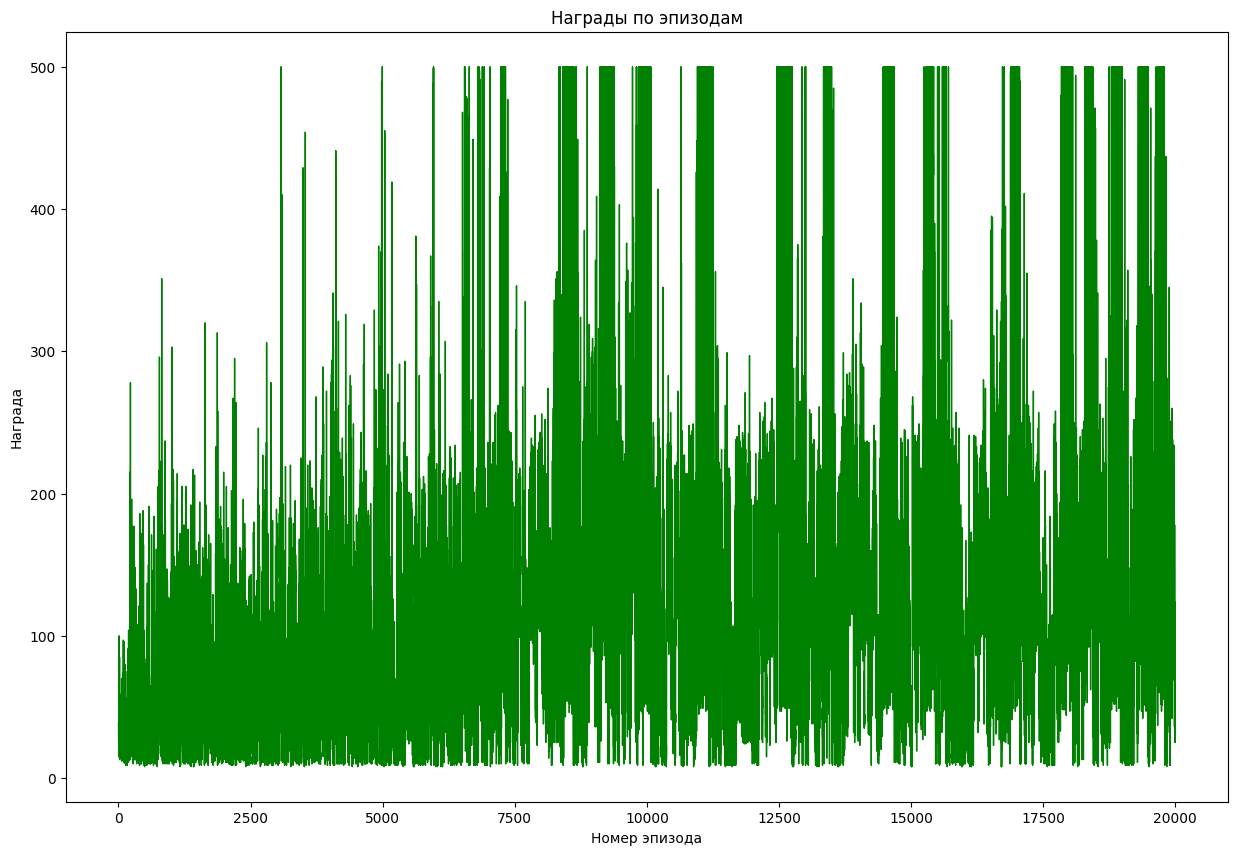

c:\Programs\python\bin\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [72]:
def run_sarsa():
    env = gym.make('CartPole-v1')
    agent = SARSA_Agent(env)
    agent.learn()
    agent.print_q()
    agent.draw_episodes_reward()
    play_agent(agent)

def run_q_learning():
    env = gym.make('CartPole-v1')
    agent = QLearning_Agent(env)
    agent.learn()
    agent.print_q()
    agent.draw_episodes_reward()
    play_agent(agent)

def run_double_q_learning():
    env = gym.make('CartPole-v1')
    agent = DoubleQLearning_Agent(env)
    agent.learn()
    agent.print_q()
    agent.draw_episodes_reward()
    play_agent(agent)

def main():
    #run_sarsa()
    #run_q_learning()
    run_double_q_learning()

if __name__ == '__main__':
    main()